## Setting Up the environment

In [724]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import scipy.stats as stats
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Accessing Clean Dataset

In [725]:
original_df1 = pd.read_csv('./dataset1_cleaned.csv', parse_dates=True)
original_df2 = pd.read_csv('./dataset2_cleaned.csv', parse_dates=True)

# copying dataframe into new variable from original variable
df1 = original_df1
df2 = original_df2

df1.head()

,start_time,bat_landing_to_food_min,habit,rat_period_start,rat_period_end,min_after_rat_arrival,risk,reward,month,sunset_time,min_after_sunset,season,date,chronology_check
0,2017-12-26 20:57:00,0.016667,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,3.983333,0,0,0,2017-12-26 16:43:00,254.916667,0,2017-12-26,True
1,2017-12-26 20:57:00,0.083333,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,3.316667,0,0,0,2017-12-26 16:43:00,254.250000,0,2017-12-26,True
2,2017-12-26 21:24:00,0.050000,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,2.016667,0,1,0,2017-12-26 16:43:00,281.616667,0,2017-12-26,True
3,2017-12-26 21:24:00,0.250000,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,1.466667,1,0,0,2017-12-26 16:43:00,281.066667,0,2017-12-26,True
4,2017-12-26 21:24:00,0.100000,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,1.883333,0,1,0,2017-12-26 16:43:00,281.483333,0,2017-12-26,True


In [726]:
df2.head()

,time,month,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,minutes_after_sunset,date
0,2017-12-26 16:13:00,0,20,4.000000,0.0,0,-30.0,2017-12-26
1,2017-12-26 16:43:00,0,28,4.000000,0.0,0,0.0,2017-12-26
2,2017-12-26 17:13:00,0,25,4.000000,0.0,0,30.0,2017-12-26
3,2017-12-26 17:43:00,0,71,4.000000,0.0,0,60.0,2017-12-26
4,2017-12-26 18:13:00,0,44,3.753857,0.0,0,90.0,2017-12-26


## Combining the two dataset

In [727]:
df1['start_time'] = pd.to_datetime(df1['start_time']).sort_values(ascending=True)
df2['time'] = pd.to_datetime(df2['time']).sort_values(ascending=True)

# converting individual bat landing time to 30 min interval time. 
df1['start_time_interval'] = df1['start_time'].dt.floor('30min').sort_values(ascending=True)
df2['time_interval'] = df2['time'].dt.floor('30min').sort_values(ascending=True)

#Merging df1 and df2
data = pd.merge(df1, df2, left_on=['date', 'start_time_interval'], right_on=['date', 'time_interval'], how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   start_time               906 non-null    datetime64[ns]
 1   bat_landing_to_food_min  906 non-null    float64       
 2   habit                    906 non-null    object        
 3   rat_period_start         906 non-null    object        
 4   rat_period_end           906 non-null    object        
 5   min_after_rat_arrival    906 non-null    float64       
 6   risk                     906 non-null    int64         
 7   reward                   906 non-null    int64         
 8   month_x                  906 non-null    int64         
 9   sunset_time              906 non-null    object        
 10  min_after_sunset         906 non-null    float64       
 11  season                   906 non-null    int64         
 12  date                     906 non-nul

## Feature Engineering

### Confirming the rat presence during bat landing
In this section, we are confirming if there was rat on food platform when bat landed.

In [728]:
data['rat_present'] = data['rat_arrival_number'].fillna(0) > 0
data['rat_present'] = data['rat_present'].astype(int)
data['rat_present'].value_counts()

rat_present
1    592
0    314
Name: count, dtype: int64

In [729]:
data.head()

,start_time,bat_landing_to_food_min,habit,rat_period_start,rat_period_end,min_after_rat_arrival,risk,reward,month_x,sunset_time,...,start_time_interval,time,month_y,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,minutes_after_sunset,time_interval,rat_present
0,2017-12-26 20:57:00,0.016667,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,3.983333,0,0,0,2017-12-26 16:43:00,...,2017-12-26 20:30:00,2017-12-26 20:43:00,0,51,2.968874,0.0,2,240.0,2017-12-26 20:30:00,1
1,2017-12-26 20:57:00,0.083333,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,3.316667,0,0,0,2017-12-26 16:43:00,...,2017-12-26 20:30:00,2017-12-26 20:43:00,0,51,2.968874,0.0,2,240.0,2017-12-26 20:30:00,1
2,2017-12-26 21:24:00,0.050000,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,2.016667,0,1,0,2017-12-26 16:43:00,...,2017-12-26 21:00:00,2017-12-26 21:13:00,0,53,2.561404,0.0,1,270.0,2017-12-26 21:00:00,1
3,2017-12-26 21:24:00,0.250000,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,1.466667,1,0,0,2017-12-26 16:43:00,...,2017-12-26 21:00:00,2017-12-26 21:13:00,0,53,2.561404,0.0,1,270.0,2017-12-26 21:00:00,1
4,2017-12-26 21:24:00,0.100000,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,1.883333,0,1,0,2017-12-26 16:43:00,...,2017-12-26 21:00:00,2017-12-26 21:13:00,0,53,2.561404,0.0,1,270.0,2017-12-26 21:00:00,1


### Food Availability Unit
We have given food availability data but the unit is unkown. So we are truning given data into fraction of 4, so it's easy to interpret. Zero (0) represent no food and 1 represent food. 

In [730]:
data['food_fraction'] = (data['food_availability'] / 4).round(2) 
data['food_fraction'].unique()

array([0.74, 0.64, 0.24, 0.18, 0.77, 0.99, 0.48, 0.59, 0.47, 0.25, 0.9 ,
       0.29, 0.8 , 0.5 , 0.26, 1.  , 0.98, 0.37, 0.51, 0.75, 0.72, 0.22,
       0.46, 0.96, 0.44, 0.61, 0.7 , 0.19, 0.69, 0.57, 0.97, 0.89, 0.52,
       0.38, 0.53, 0.78, 0.49, 0.28, 0.62, 0.73, 0.65, 0.56, 0.86, 0.36,
       0.87, 0.76, 0.71, 0.6 , 0.58, 0.45, 0.93, 0.2 ])

### Creating a Seasons Feature
The Egyptian weather pattern is completely different from Australia. As winter generally falls in December to Februaru, while Spring falls from March to May in Egypt. Beside this, it also help us with our investigation, where we can see the behaviours based on seasonal changes.

In [731]:
# Extracting the month from the 'date' column in merged dataset.
data['month_num'] = pd.to_datetime(data['date']).dt.month

# Defining a function to categorize months into Egyptian Seasons
def egyptian_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    else:
        return 'Other'
    
# Creating new 'season_egypt' column
data['season_egypt'] = data['month_num'].apply(egyptian_season)

In [732]:
data['season_egypt'].unique()

array(['Winter', 'Spring'], dtype=object)

### Counting the number of bat landing 

In [733]:
bat_count = (data.groupby(["date","start_time_interval"]).size()
             .rename("bat_count").reset_index())
data = data.merge(bat_count, on=["date","start_time_interval"], how="left")

### Comparing number of rat vs bat

In [734]:
data['rats_more_than_bats'] = (data['rat_arrival_number'] > data['bat_count']).astype(int)
data['rats_more_than_bats'].unique()

array([0, 1])

### Interactive Terms

In [735]:
# calculating bat risk taking behavior in presence of rat
data['risk_rat_present'] = (data['rats_more_than_bats'] * data['risk']) 

# calculating bat risk taking behavior difference in food availability
data['risk_food_availability'] = (data['food_fraction'] * data['risk']) 

In [736]:
# Calculating bat risk taking behaviour underdifferent category with reward
data['risk_reward'] = data['risk_rat_present'] * data['risk_food_availability'] * data['reward']

## Data Cleaning
The merged dataframe might contains duplicate and redundant columns after the join. This step will clean up the merged dataframe by dropping unnecessary columns and renaming columns for clarity

In [737]:
# Dropping redundant columns after merging
data = data.drop(columns=['time', 'time_interval', 'start_time_interval', 'food_availability', 'season', 'month_y', 'month_x', 'minutes_after_sunset', 'habit','start_time','rat_period_start','rat_period_end','sunset_time', 'date','chronology_check'])

# Renaming Columns for clarity 
data = data.rename(columns={'month_num': 'month'})

data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bat_landing_to_food_min  906 non-null    float64
 1   min_after_rat_arrival    906 non-null    float64
 2   risk                     906 non-null    int64  
 3   reward                   906 non-null    int64  
 4   min_after_sunset         906 non-null    float64
 5   bat_landing_number       906 non-null    int64  
 6   rat_minutes              906 non-null    float64
 7   rat_arrival_number       906 non-null    int64  
 8   rat_present              906 non-null    int64  
 9   food_fraction            906 non-null    float64
 10  month                    906 non-null    int32  
 11  season_egypt             906 non-null    object 
 12  bat_count                906 non-null    int64  
 13  rats_more_than_bats      906 non-null    int64  
 14  risk_rat_present         9

## Preparing data for regression
We are encoding the data, as linear regression requires numerical inputs. So any categorical features must be converted into numbers in a way that preserves meaning.

* __Dependent Variable (Y):__ `bat_landing_to_food_min`
* __Predictors (X):__ `rat_present`, `food_fraction`, `bat_count`, `rat_minutes`, `minutes_after_sunsets`


### One-hot encoding for categorical values

In [738]:
#copying original data for encoding 
enc_data = data

# selecting categorical columns
categorical_cols = ['season_egypt']

#creating one-hot encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = pd.DataFrame(
    encoder.fit_transform(enc_data[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols)
)

# Merging encoded columns back into main Dataframe
enc_data = pd.concat([enc_data.drop(columns=categorical_cols).reset_index(drop=True),
                          encoded_data.reset_index(drop=True)], axis = 1)

#Interactive terms
enc_data['seasonal_rat_present'] = enc_data['season_egypt_Winter'] * enc_data['rat_present']
enc_data['seasonal_food_availability'] = enc_data['season_egypt_Winter'] * enc_data['food_fraction']

### Grouping data based on season
We are grouping dataframe by season. Then we will use 80% - 20% data train and test our linear regression.  

In [739]:
winter_df = enc_data[enc_data['season_egypt_Winter'] == 1.0]
spring_df = enc_data[enc_data['season_egypt_Winter'] == 0.0]


## Features to be use

In [740]:
target_col = 'bat_landing_to_food_min'

cols_to_exclude = {
     target_col, 'start_time', 'rat_period_start', 'rat_period_end', 'sunset_time',
    'date', 'chronology_check', 'month', 'month_num', 'minutes_after_sunset', }

features = [
    col for col in enc_data.columns
    if col not in cols_to_exclude
    ]
# features = [
#  'risk_reward', 'season_egypt_Winter', 'min_after_sunset',    
# ]

# X_winter = winter_df[features]
# Y_winter = winter_df['bat_landing_to_food_min']

# X_spring = spring_df[features]
# Y_spring = spring_df['bat_landing_to_food_min']

In [741]:
X = enc_data[features].copy()
X.corr()

## pair of independent ariables with correlation greater than 0.5 
k=X.corr()
z=[[str(i),str(j)] for i in k.columns for j in k.columns if(k.loc[i,j]>abs(0.5))&(i!=j)]
z,len(z)

#importing varience inflation factor from the stats model
vif_data=X
## calculating VIF for every column
VIF=pd.Series([variance_inflation_factor(vif_data.values,i) for i in range(vif_data.shape[1])],index=vif_data.columns)
print(VIF)

min_after_rat_arrival          2.712601
risk                          24.834842
reward                         3.520749
min_after_sunset               6.044259
bat_landing_number             6.106911
rat_minutes                    1.056786
rat_arrival_number            10.466661
rat_present                   13.036890
food_fraction                 11.127209
bat_count                      4.531445
rats_more_than_bats            2.187208
risk_rat_present               2.331444
risk_food_availability        25.243069
risk_reward                    1.377818
season_egypt_Winter           13.061587
seasonal_rat_present           4.715729
seasonal_food_availability     9.487039
dtype: float64


# Log transformations

## Visualising the variables

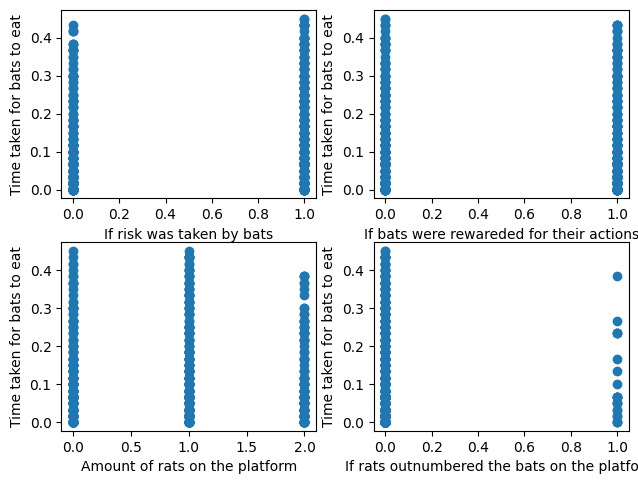

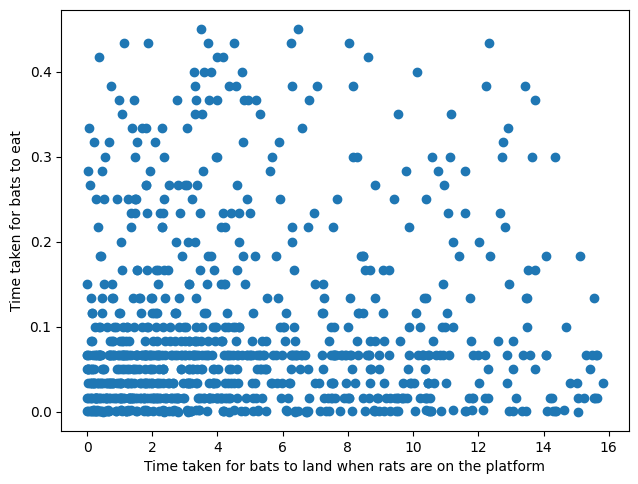

In [742]:
data2 = data.drop(columns=['season_egypt'])
# Read dataset into a DataFrame
fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
fig1.tight_layout()

""" FIGURE 1 """
ax1.scatter(x = data2['risk'], y = data2['bat_landing_to_food_min'])
ax1.set_xlabel("If risk was taken by bats")
ax1.set_ylabel("Time taken for bats to eat")

ax2.scatter(x = data2['reward'], y = data2['bat_landing_to_food_min'])
ax2.set_xlabel("If bats were rewareded for their actions")
ax2.set_ylabel("Time taken for bats to eat")

ax3.scatter(x = data2['rat_arrival_number'], y = data2['bat_landing_to_food_min'])
ax3.set_xlabel("Amount of rats on the platform")
ax3.set_ylabel("Time taken for bats to eat")

ax4.scatter(x = data2['rats_more_than_bats'], y = data2['bat_landing_to_food_min'])
ax4.set_xlabel("If rats outnumbered the bats on the platform")
ax4.set_ylabel("Time taken for bats to eat")

plt.show()

fig1, ((ax1)) = plt.subplots(nrows=1, ncols=1)
fig1.tight_layout()
ax1.scatter(x = data2['min_after_rat_arrival'], y = data2['bat_landing_to_food_min'])
ax1.set_xlabel("Time taken for bats to land when rats are on the platform")
ax1.set_ylabel("Time taken for bats to eat")
plt.show()

## Log Baseline

In [743]:
logdata = data2[['min_after_rat_arrival', 'risk', 'reward', 'rat_arrival_number', 'rats_more_than_bats']]

model = sm.OLS(data2['bat_landing_to_food_min'], logdata).fit()
pred = model.predict(logdata)
model_details = model.summary()
print(model_details)

                                   OLS Regression Results                                   
Dep. Variable:     bat_landing_to_food_min   R-squared (uncentered):                   0.475
Model:                                 OLS   Adj. R-squared (uncentered):              0.473
Method:                      Least Squares   F-statistic:                              163.3
Date:                     Thu, 16 Oct 2025   Prob (F-statistic):                   1.42e-123
Time:                             03:37:51   Log-Likelihood:                          799.77
No. Observations:                      906   AIC:                                     -1590.
Df Residuals:                          901   BIC:                                     -1566.
Df Model:                                5                                                  
Covariance Type:                 nonrobust                                                  
                            coef    std err          t      P>|t|     

## Risk Log Transformation

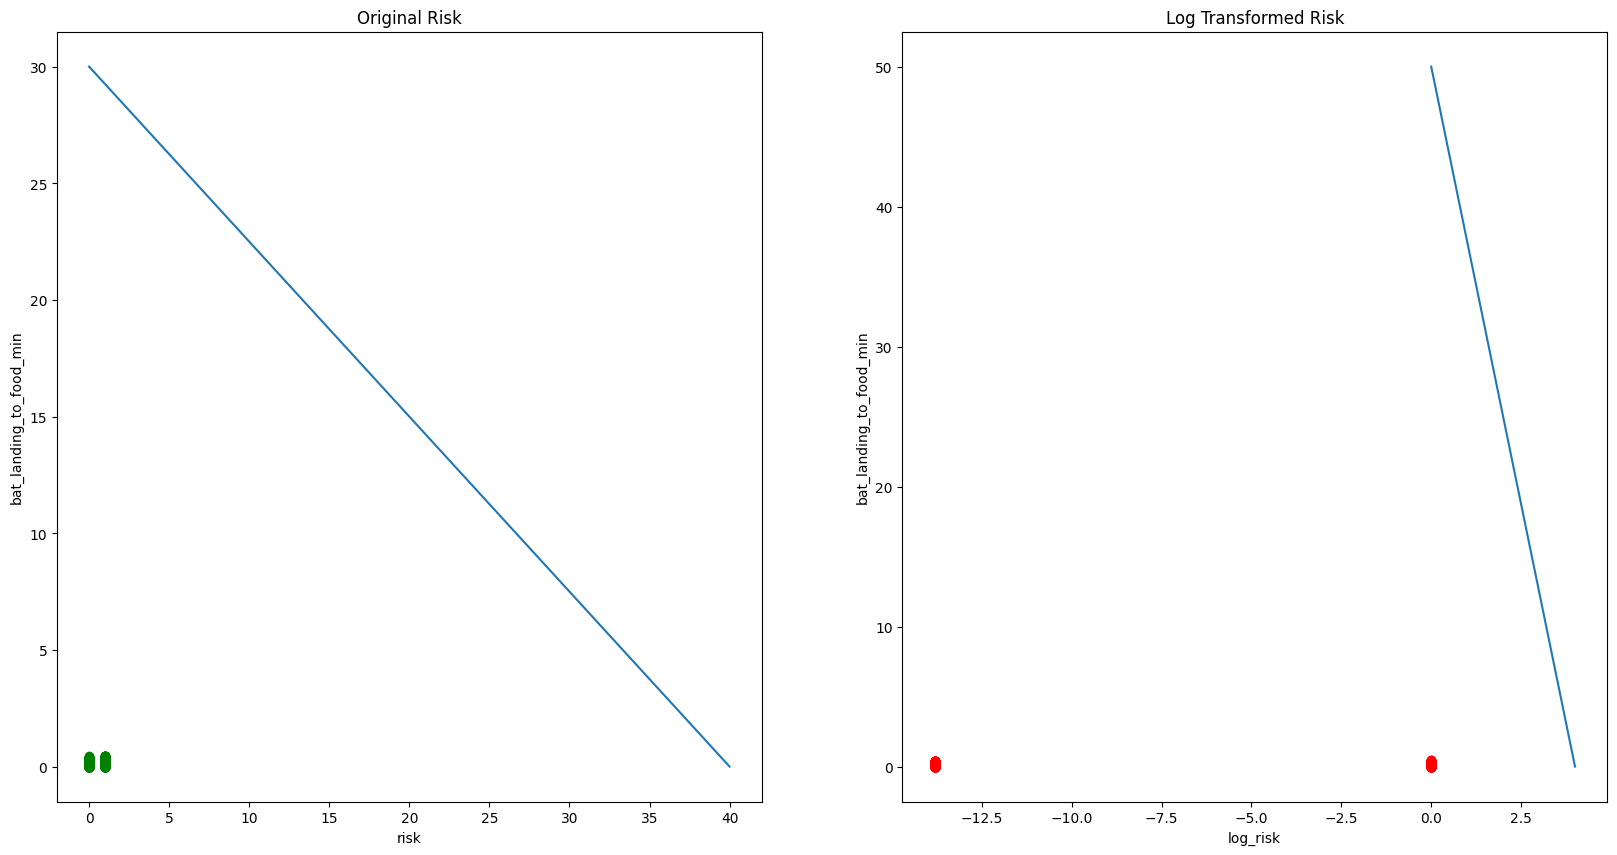

                                   OLS Regression Results                                   
Dep. Variable:     bat_landing_to_food_min   R-squared (uncentered):                   0.379
Model:                                 OLS   Adj. R-squared (uncentered):              0.375
Method:                      Least Squares   F-statistic:                              109.7
Date:                     Thu, 16 Oct 2025   Prob (F-statistic):                    1.49e-90
Time:                             03:37:52   Log-Likelihood:                          722.98
No. Observations:                      906   AIC:                                     -1436.
Df Residuals:                          901   BIC:                                     -1412.
Df Model:                                5                                                  
Covariance Type:                 nonrobust                                                  
                            coef    std err          t      P>|t|     

In [744]:
data2['log_risk'] = np.log(data2['risk'] + 1e-6)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(data2['risk'], data2['bat_landing_to_food_min'], color="green")
plt.title("Original Risk")
plt.xlabel("risk")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,40],[30,0])

plt.subplot(1,2,2)
plt.scatter(data2['log_risk'], data2['bat_landing_to_food_min'], color="red")
plt.title("Log Transformed Risk")
plt.xlabel("log_risk")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,4],[50,0])

plt.show()

logdata = data2[['min_after_rat_arrival', 'log_risk', 'reward', 'rat_arrival_number', 'rats_more_than_bats']]

model = sm.OLS(data2['bat_landing_to_food_min'],logdata).fit()
pred = model.predict(logdata)
model_details = model.summary()
print(model_details)

This results in a less accurate model (lower R-squared), so it will not be kept

## Reward Log Transformation

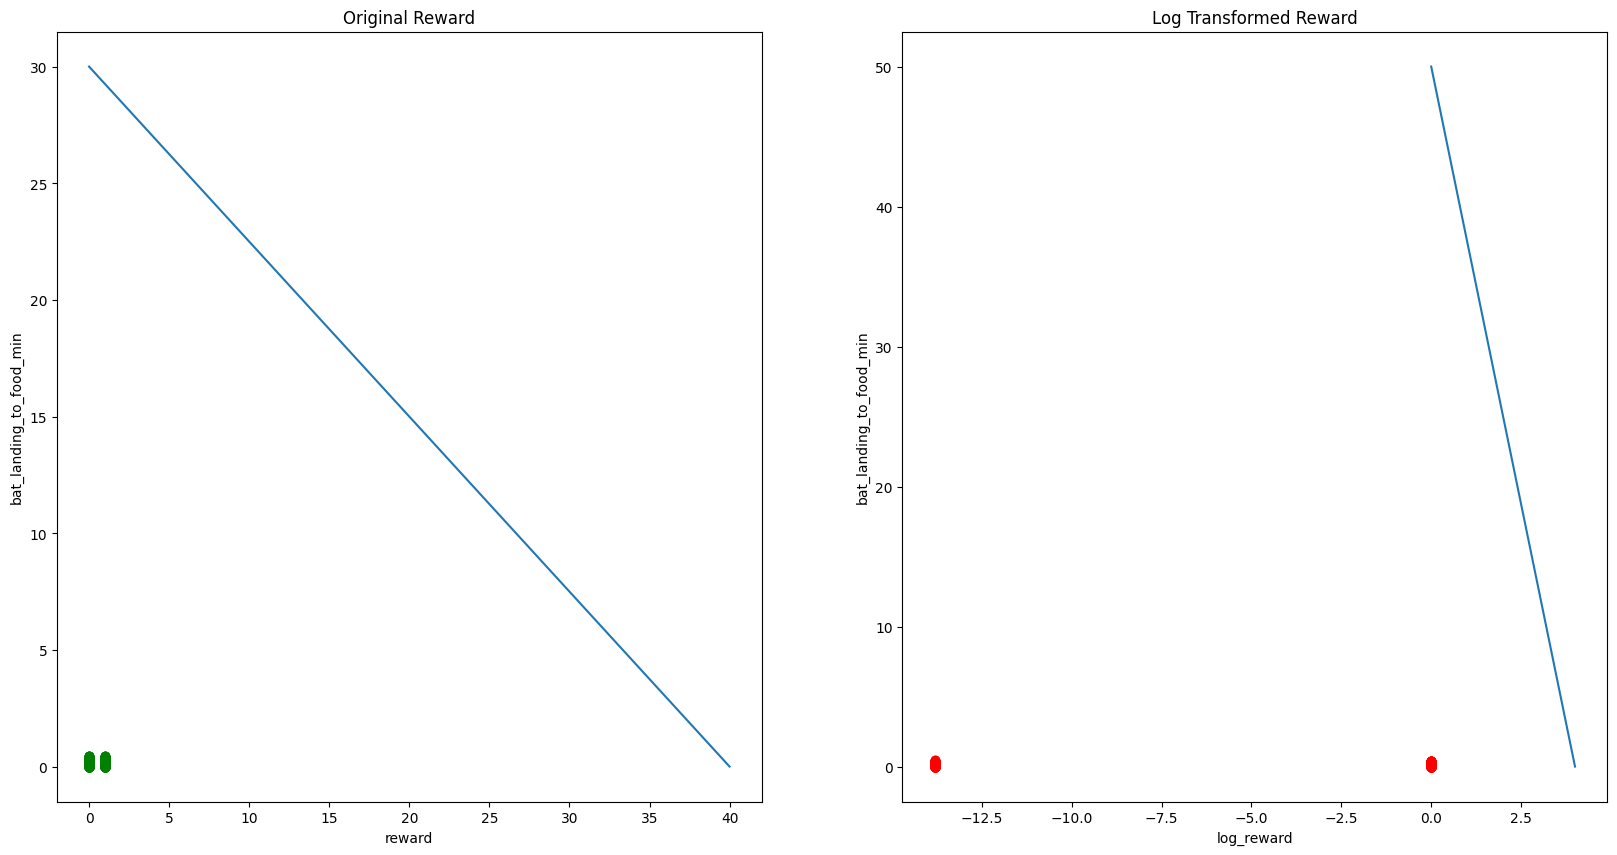

                                   OLS Regression Results                                   
Dep. Variable:     bat_landing_to_food_min   R-squared (uncentered):                   0.441
Model:                                 OLS   Adj. R-squared (uncentered):              0.438
Method:                      Least Squares   F-statistic:                              142.1
Date:                     Thu, 16 Oct 2025   Prob (F-statistic):                   3.91e-111
Time:                             03:37:54   Log-Likelihood:                          770.86
No. Observations:                      906   AIC:                                     -1532.
Df Residuals:                          901   BIC:                                     -1508.
Df Model:                                5                                                  
Covariance Type:                 nonrobust                                                  
                            coef    std err          t      P>|t|     

In [745]:
data2['log_reward'] = np.log(data2['reward'] + 1e-6)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(data2['reward'], data2['bat_landing_to_food_min'], color="green")
plt.title("Original Reward")
plt.xlabel("reward")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,40],[30,0])

plt.subplot(1,2,2)
plt.scatter(data2['log_reward'], data2['bat_landing_to_food_min'], color="red")
plt.title("Log Transformed Reward")
plt.xlabel("log_reward")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,4],[50,0])

plt.show()

logdata = data2[['min_after_rat_arrival', 'risk','log_reward', 'rat_arrival_number', 'rats_more_than_bats']]

model = sm.OLS(data2['bat_landing_to_food_min'],logdata).fit()
pred = model.predict(logdata)
model_details = model.summary()
print(model_details)

This results in a less accurate model (lower R-squared), so it will not be kept

## rat_arrival_number Log Transformation

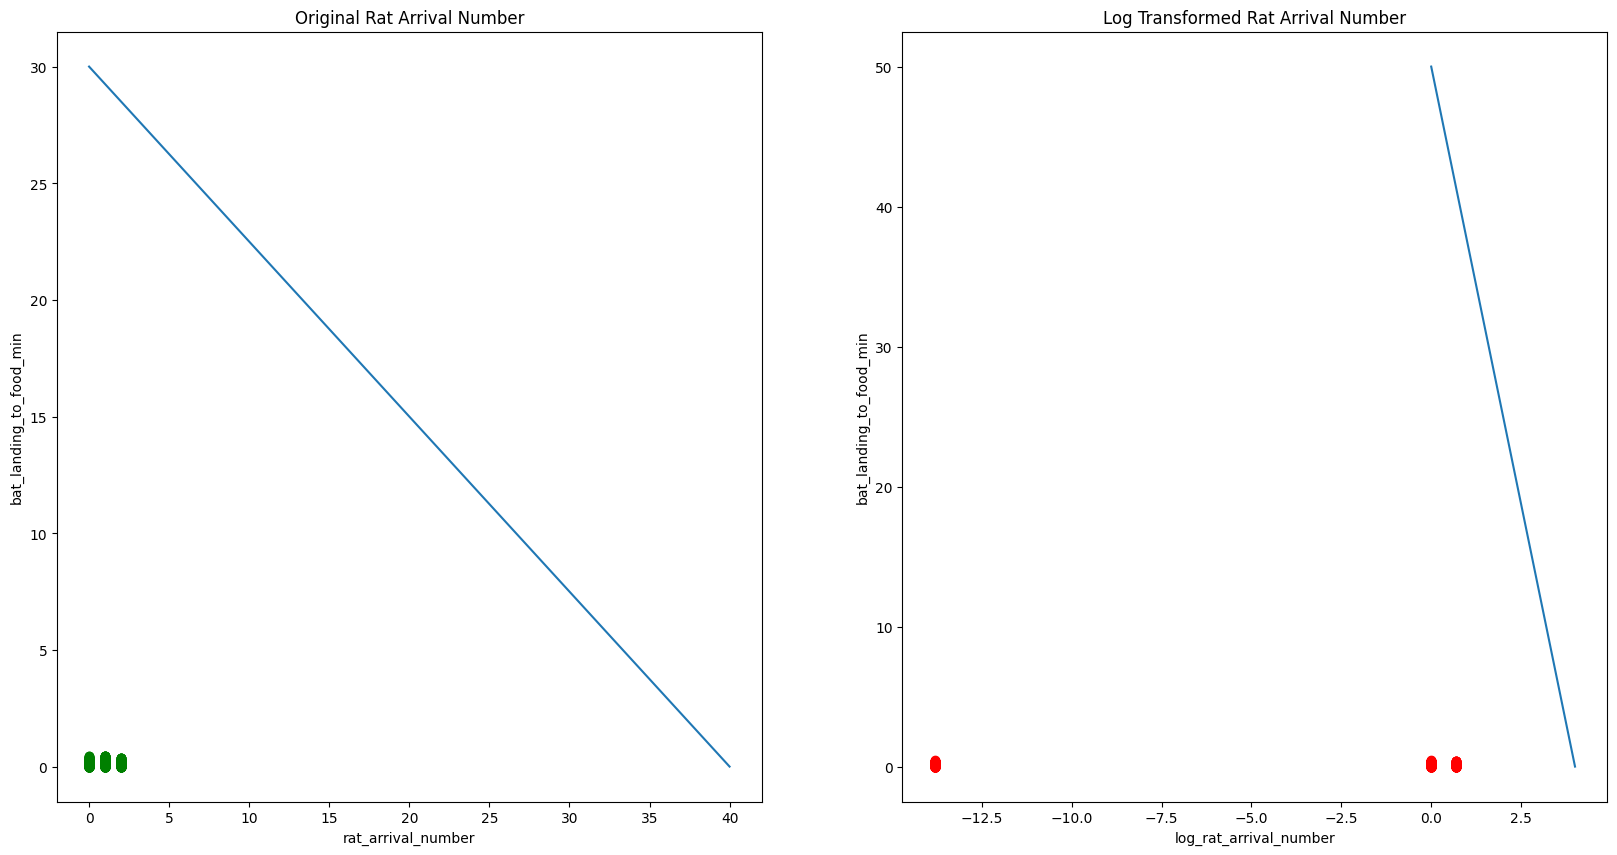

                                   OLS Regression Results                                   
Dep. Variable:     bat_landing_to_food_min   R-squared (uncentered):                   0.473
Model:                                 OLS   Adj. R-squared (uncentered):              0.470
Method:                      Least Squares   F-statistic:                              161.9
Date:                     Thu, 16 Oct 2025   Prob (F-statistic):                   8.73e-123
Time:                             03:37:57   Log-Likelihood:                          797.94
No. Observations:                      906   AIC:                                     -1586.
Df Residuals:                          901   BIC:                                     -1562.
Df Model:                                5                                                  
Covariance Type:                 nonrobust                                                  
                             coef    std err          t      P>|t|    

In [746]:
data2['log_rat_arrival_number'] = np.log(data2['rat_arrival_number'] + 1e-6)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(data2['rat_arrival_number'], data2['bat_landing_to_food_min'], color="green")
plt.title("Original Rat Arrival Number")
plt.xlabel("rat_arrival_number")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,40],[30,0])

plt.subplot(1,2,2)
plt.scatter(data2['log_rat_arrival_number'], data2['bat_landing_to_food_min'], color="red")
plt.title("Log Transformed Rat Arrival Number")
plt.xlabel("log_rat_arrival_number")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,4],[50,0])

plt.show()

logdata = data2[['min_after_rat_arrival', 'risk','reward', 'log_rat_arrival_number', 'rats_more_than_bats']]

model = sm.OLS(data2['bat_landing_to_food_min'],logdata).fit()
pred = model.predict(logdata)
model_details = model.summary()
print(model_details)

This results in a less accurate model (lower R-squared), so it will not be kept

## Rats More Than Bats

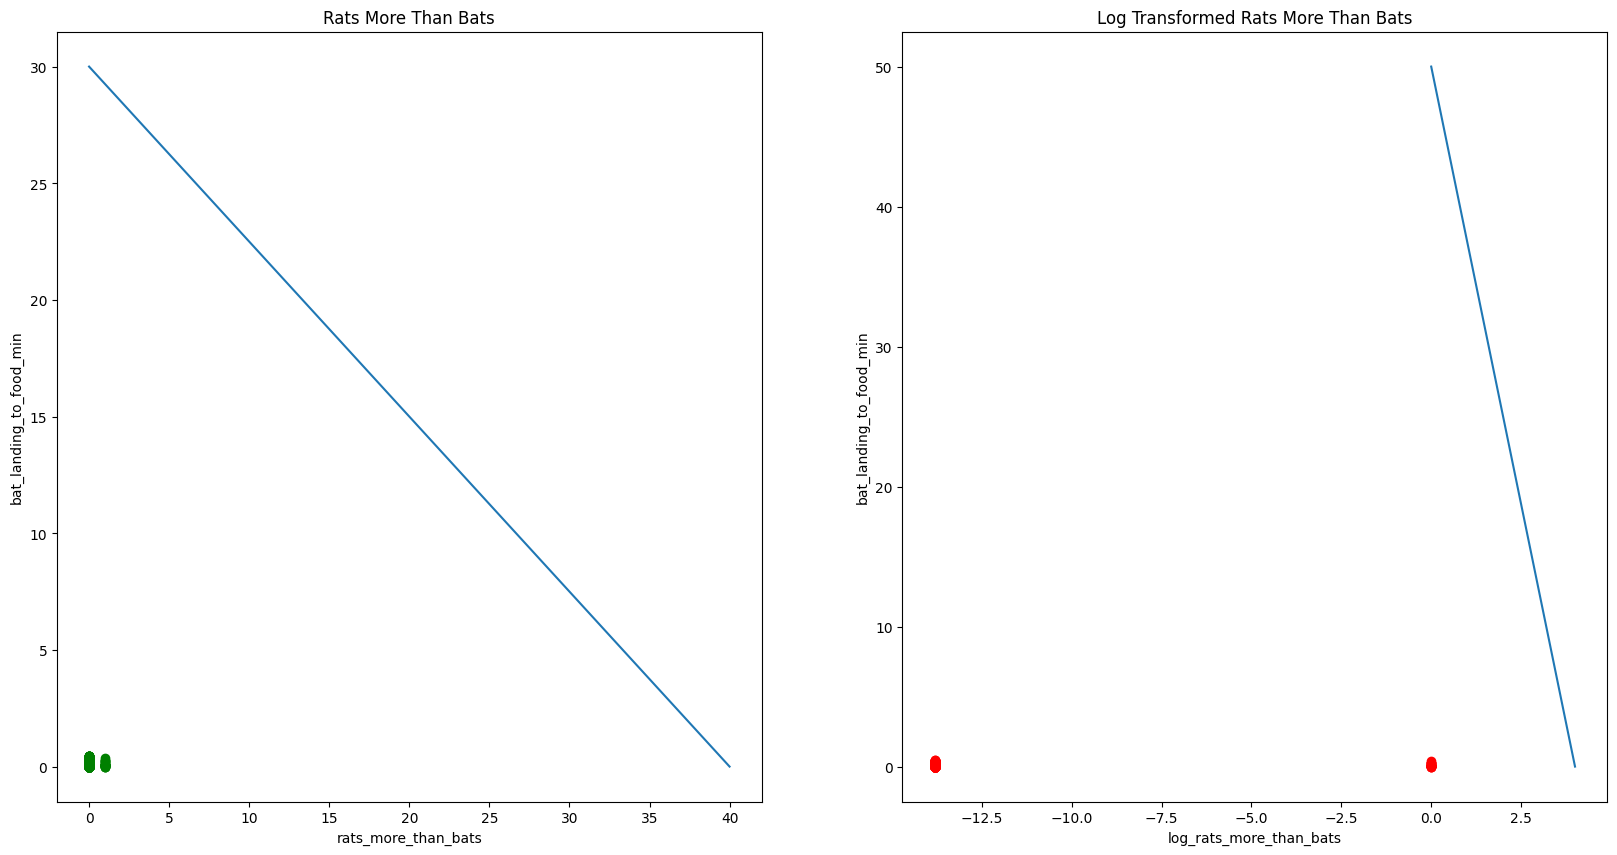

                                   OLS Regression Results                                   
Dep. Variable:     bat_landing_to_food_min   R-squared (uncentered):                   0.480
Model:                                 OLS   Adj. R-squared (uncentered):              0.477
Method:                      Least Squares   F-statistic:                              166.5
Date:                     Thu, 16 Oct 2025   Prob (F-statistic):                   2.38e-125
Time:                             03:38:00   Log-Likelihood:                          803.90
No. Observations:                      906   AIC:                                     -1598.
Df Residuals:                          901   BIC:                                     -1574.
Df Model:                                5                                                  
Covariance Type:                 nonrobust                                                  
                              coef    std err          t      P>|t|   

In [747]:
data2['log_rats_more_than_bats'] = np.log(data2['rats_more_than_bats'] + 1e-6)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(data2['rats_more_than_bats'], data2['bat_landing_to_food_min'], color="green")
plt.title("Rats More Than Bats")
plt.xlabel("rats_more_than_bats")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,40],[30,0])

plt.subplot(1,2,2)
plt.scatter(data2['log_rats_more_than_bats'], data2['bat_landing_to_food_min'], color="red")
plt.title("Log Transformed Rats More Than Bats")
plt.xlabel("log_rats_more_than_bats")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,4],[50,0])

plt.show()

logdata = data2[['min_after_rat_arrival', 'risk','reward', 'rat_arrival_number', 'log_rats_more_than_bats']]

model = sm.OLS(data2['bat_landing_to_food_min'],logdata).fit()
pred = model.predict(logdata)
model_details = model.summary()
print(model_details)

This results in a more accurate model (higher R-squared), so it will be kept

## Minutes After Rat Arrival Log Transformation

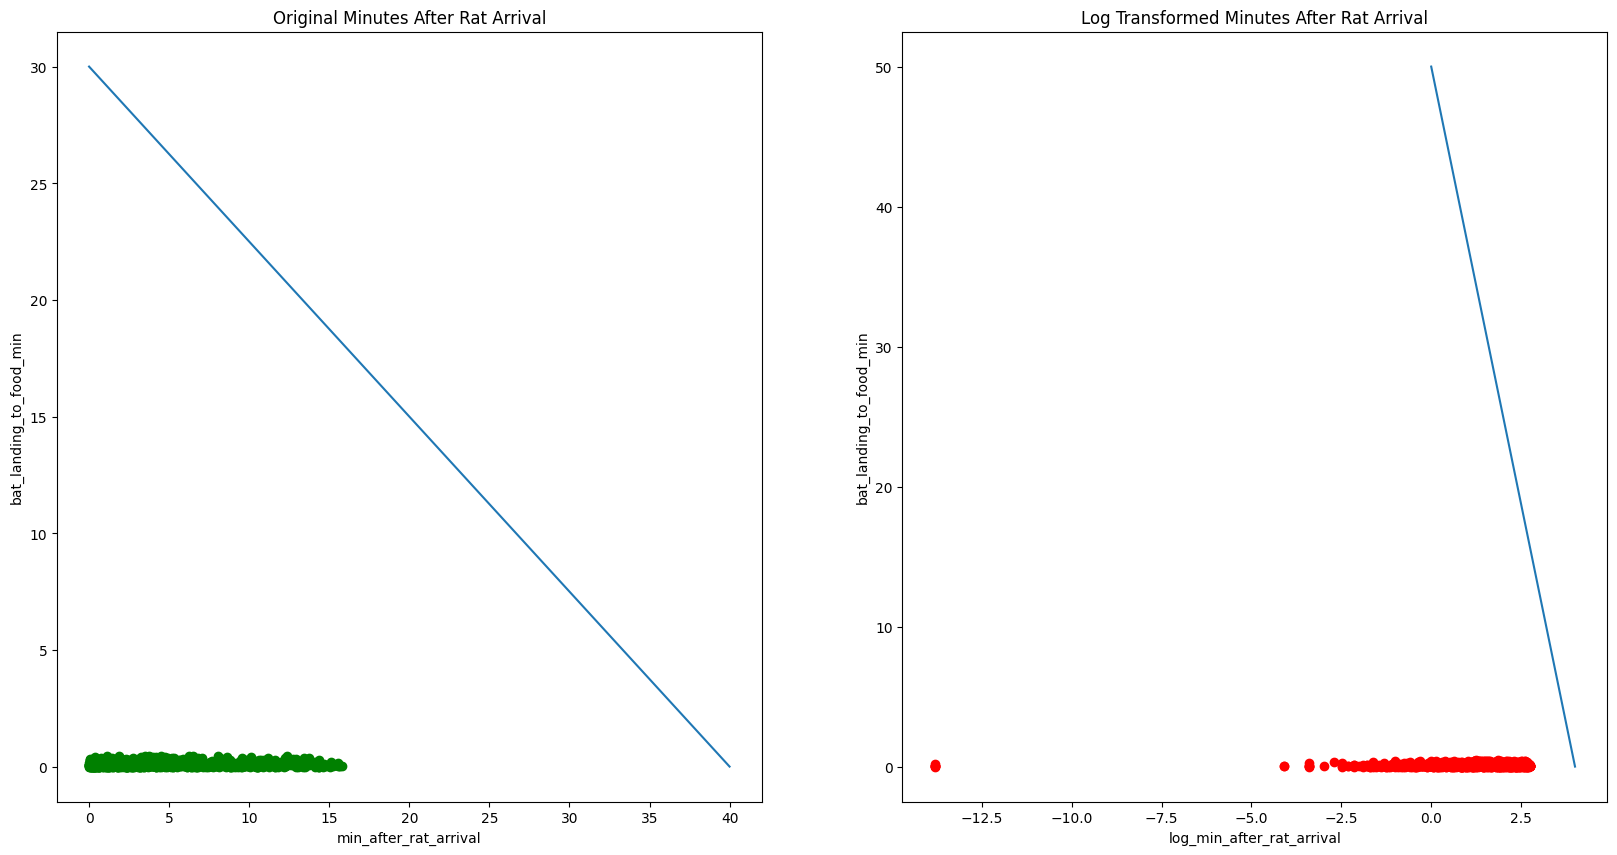

                                   OLS Regression Results                                   
Dep. Variable:     bat_landing_to_food_min   R-squared (uncentered):                   0.475
Model:                                 OLS   Adj. R-squared (uncentered):              0.472
Method:                      Least Squares   F-statistic:                              163.2
Date:                     Thu, 16 Oct 2025   Prob (F-statistic):                   1.63e-123
Time:                             03:38:04   Log-Likelihood:                          799.63
No. Observations:                      906   AIC:                                     -1589.
Df Residuals:                          901   BIC:                                     -1565.
Df Model:                                5                                                  
Covariance Type:                 nonrobust                                                  
                                coef    std err          t      P>|t| 

In [748]:
data2['log_min_after_rat_arrival'] = np.log(data2['min_after_rat_arrival'] + 1e-6)
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.scatter(data2['min_after_rat_arrival'], data2['bat_landing_to_food_min'], color="green")
plt.title("Original Minutes After Rat Arrival")
plt.xlabel("min_after_rat_arrival")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,40],[30,0])

plt.subplot(1,2,2)
plt.scatter(data2['log_min_after_rat_arrival'], data2['bat_landing_to_food_min'], color="red")
plt.title("Log Transformed Minutes After Rat Arrival")
plt.xlabel("log_min_after_rat_arrival")
plt.ylabel("bat_landing_to_food_min")
plt.plot([0,4],[50,0])

plt.show()

logdata = data2[['log_min_after_rat_arrival', 'risk','reward', 'rat_arrival_number', 'rats_more_than_bats']]

model = sm.OLS(data2['bat_landing_to_food_min'],logdata).fit()
pred = model.predict(logdata)
model_details = model.summary()
print(model_details)

This results in a less accurate model (lower R-squared), so it will not be kept

# MultiColinearity heatmap

<Figure size 1200x1000 with 0 Axes>

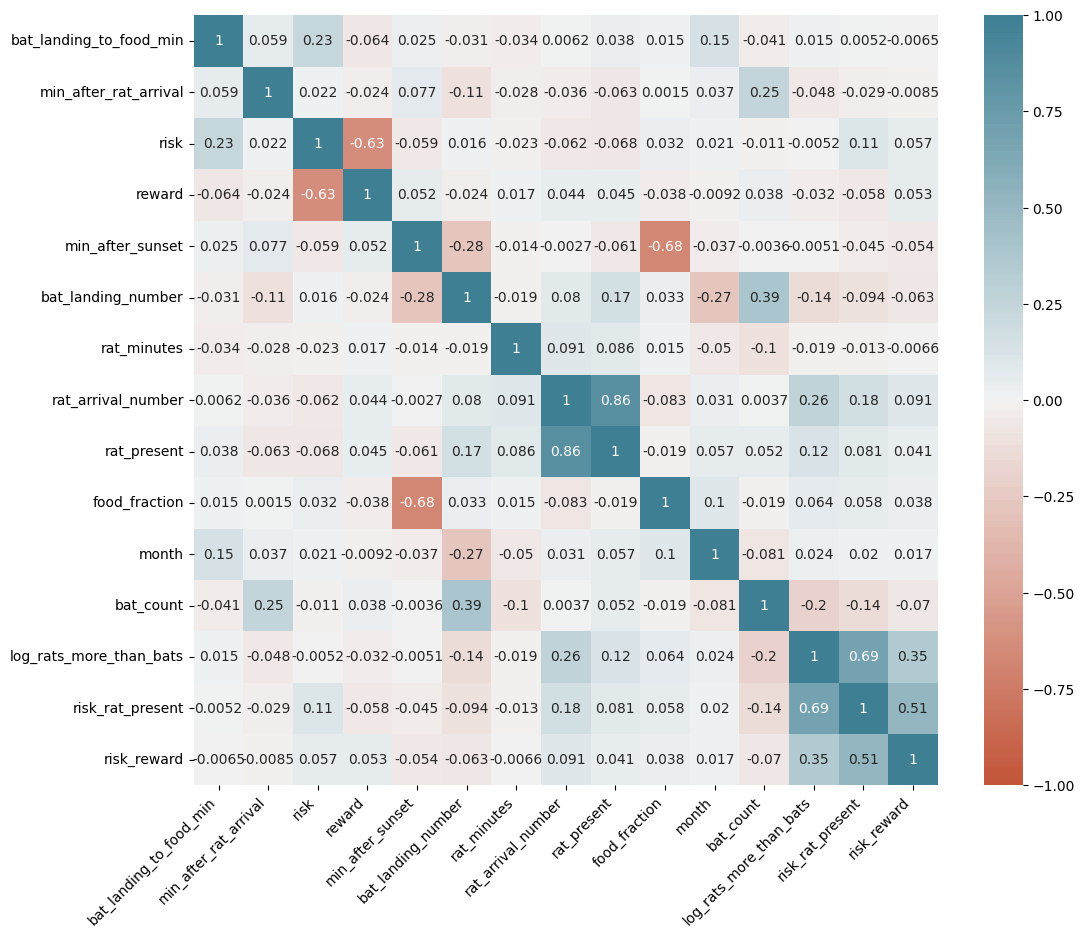

In [749]:
#'season_egypt','risk','reward','min_after_sunset','bat_landing_number','rat_minutes','rat_arrival_number','rat_present','food_fraction','bat_count','rats_more_than_bats','risk_rat_present','risk_food_availability','risk_reward',])
corr2 = data2.corr()

plt.figure(figsize=(12, 10))  # Adjust width and height as needed

chosen_vars = ['bat_landing_to_food_min', 'min_after_rat_arrival', 'risk', 'reward',
       'min_after_sunset', 'bat_landing_number', 'rat_minutes',
       'rat_arrival_number', 'rat_present', 'food_fraction', 'month', 'bat_count', 'log_rats_more_than_bats', 'risk_rat_present', 'risk_reward']
corr_subset = corr2.loc[chosen_vars, chosen_vars]

plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    corr_subset, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
    annot=True
)
# customise the labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [756]:
def MC_remover(data):
    vif=pd.Series([variance_inflation_factor(data.values,i)for i in range(data.shape[1])],index=data.columns)
    if vif.max()>5:
        print(vif[vif == vif.max()].index[0],'has been removed')
        data = data.drop(columns=[vif[vif==vif.max()].index[0]])
        return data
    else:
        print("No multicollinearity present anymore")
        return data

In [757]:
for i in range(10):
    vif_data=MC_remover(vif_data)

No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore
No multicollinearity present anymore


In [758]:
## calculating VIF for remaining columns
VIF=pd.Series([variance_inflation_factor(vif_data.values,i) for i in range(vif_data.shape[1])],index=vif_data.columns)
VIF,len(vif_data.columns)

(min_after_rat_arrival         2.537626
 risk                          2.397978
 reward                        2.654683
 min_after_sunset              4.476932
 rat_minutes                   1.052920
 rat_arrival_number            2.551056
 bat_count                     3.184185
 rats_more_than_bats           2.098519
 risk_rat_present              2.322331
 risk_reward                   1.372506
 seasonal_rat_present          2.915968
 seasonal_food_availability    2.746748
 dtype: float64,
 12)

In [761]:
w_features = ['min_after_rat_arrival', 'risk', 'reward', 'rat_arrival_number',  
                'log_rats_more_than_bats', 'season_egypt_Winter']
s_features = ['min_after_rat_arrival', 'risk', 'reward', 'min_after_sunset', 'rat_minutes',  
                'season_egypt_Winter']
y_features = ['min_after_rat_arrival', 'risk', 'reward', 'rat_arrival_number', 
                'log_rats_more_than_bats']
# new_features = ['min_after_rat_arrival', 'risk', 'reward', 'min_after_sunset', 'rat_minutes', 'rat_arrival_number',  
                # 'rats_more_than_bats', 'seasonal_rat_present', 'seasonal_food_availability']

## Regression Logic

### Train/Test split within each season

In [771]:
winter_df.loc[:, 'log_rats_more_than_bats'] = data2['log_rats_more_than_bats']
data.loc[:, 'log_rats_more_than_bats'] = data2['log_rats_more_than_bats']

In [772]:

def split_xy(df, feature_cols, target_col, test_size=0.2, random_state = 42):
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

Xw_train, Xw_test, yw_train, yw_test = split_xy(winter_df, w_features, target_col)
Xs_train, Xs_test, ys_train, ys_test = split_xy(spring_df, s_features, target_col)

In [773]:
year_df = data.drop(columns=['season_egypt'])
Xy_train, Xy_test, yy_train, yy_test = split_xy(year_df, y_features, target_col)

### Standardising the Data
After standardising the data, every varibale will be on same scale, avoiding issues with large-value feature dominate smaller ones like min_after_sunset and food_fraction

In [774]:
# Winter scaler (fit on winter train only)
winter_scaler = StandardScaler()
Xw_train_scaled = winter_scaler.fit_transform(Xw_train)
Xw_test_scaled  = winter_scaler.transform(Xw_test)

# Spring scaler (fit on spring train only)
spring_scaler = StandardScaler()
Xs_train_scaled = spring_scaler.fit_transform(Xs_train)
Xs_test_scaled  = spring_scaler.transform(Xs_test)

In [775]:
# year scaler (fit on spring train only)
year_scaler = StandardScaler()
Xy_train_scaled = year_scaler.fit_transform(Xy_train)
Xy_test_scaled  = year_scaler.transform(Xy_test)

## Linear Regression

In [776]:
LRwinter = LinearRegression().fit(Xw_train_scaled, yw_train)
LRspring = LinearRegression().fit(Xs_train_scaled, ys_train)

In [777]:
LRyear = LinearRegression().fit(Xy_train_scaled, yy_train)

## Regression Coefficients

In [778]:
coef_winter = pd.Series(LRwinter.coef_, index=w_features).sort_values(key=abs, ascending=False)
coef_spring = pd.Series(LRspring.coef_, index=s_features).sort_values(key=abs, ascending=False)

In [779]:
coef_year = pd.Series(LRyear.coef_, index=y_features).sort_values(key=abs, ascending=False)

### Feature Importance Visualization

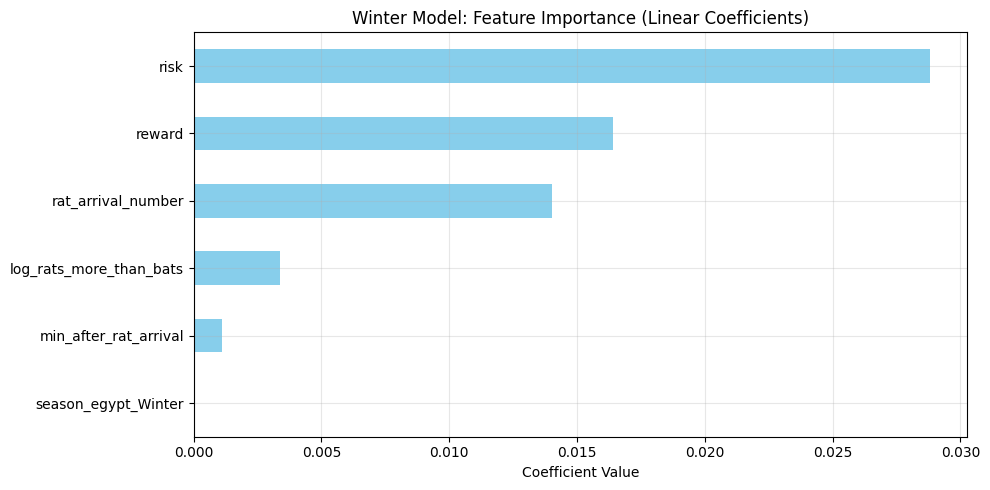

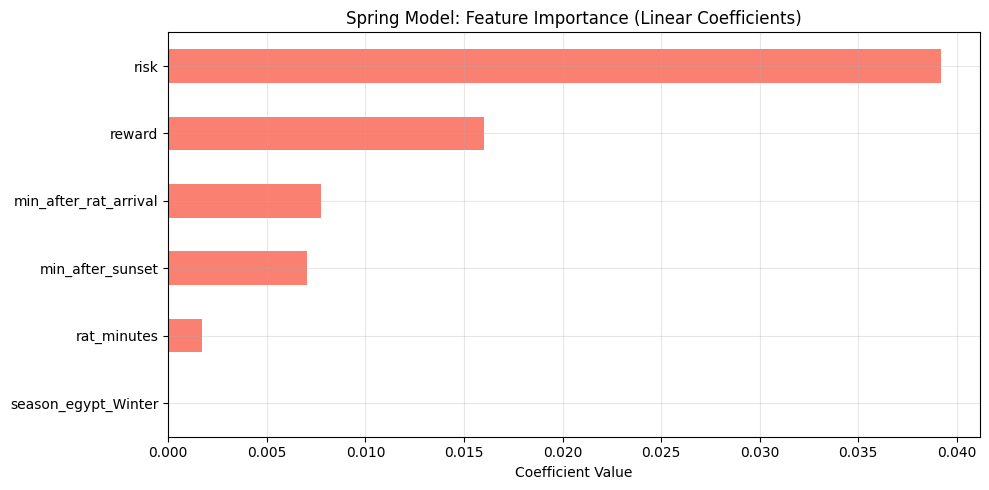

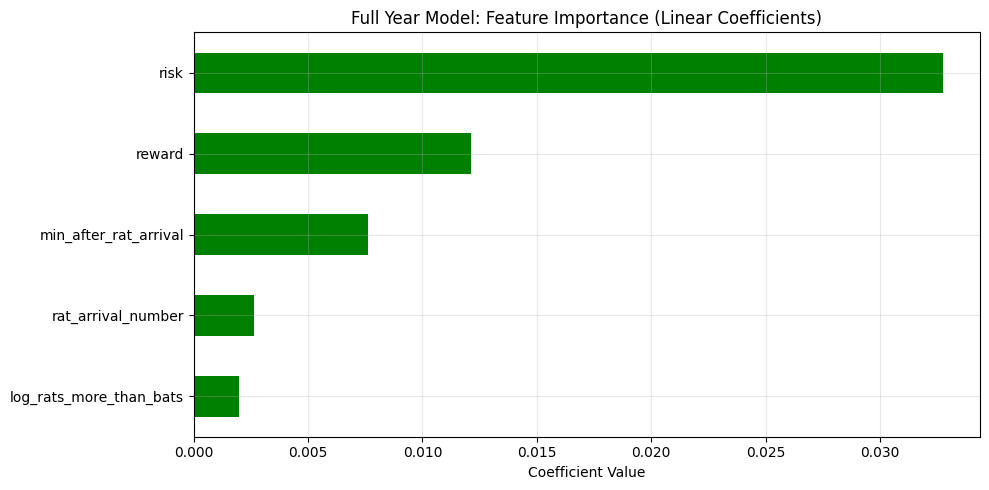

In [780]:
# --- Feature Importance (Absolute Coefficients) ---


# Plot Winter Coefficients
plt.figure(figsize=(10, 5))
coef_winter.sort_values(key=abs, ascending=True).plot(kind='barh', color='skyblue')
plt.title("Winter Model: Feature Importance (Linear Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Spring Coefficients
plt.figure(figsize=(10, 5))
coef_spring.sort_values(key=abs, ascending=True).plot(kind='barh', color='salmon')
plt.title("Spring Model: Feature Importance (Linear Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot Year Coefficients
plt.figure(figsize=(10, 5))
coef_year.sort_values(key=abs, ascending=True).plot(kind='barh', color='green')
plt.title("Full Year Model: Feature Importance (Linear Coefficients)")
plt.xlabel("Coefficient Value")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [781]:
coef_winter.head(10)

risk                       0.028823
reward                     0.016397
rat_arrival_number         0.014022
log_rats_more_than_bats    0.003377
min_after_rat_arrival      0.001114
season_egypt_Winter        0.000000
dtype: float64

In [782]:
coef_spring.head(10)

risk                     0.039212
reward                   0.016024
min_after_rat_arrival    0.007732
min_after_sunset         0.007056
rat_minutes              0.001738
season_egypt_Winter      0.000000
dtype: float64

In [783]:
coef_year.head(10)

risk                       0.032739
reward                     0.012110
min_after_rat_arrival      0.007616
rat_arrival_number         0.002624
log_rats_more_than_bats    0.001983
dtype: float64

## MSE, RMSE and R square - Training Dataset

In [784]:
# Predict values for each model
y_pred_winter = LRwinter.predict(Xw_train_scaled)
y_pred_spring = LRspring.predict(Xs_train_scaled)
y_pred_year = LRyear.predict(Xy_train_scaled)

print(f'y_pred_winter: {y_pred_winter}')
print(f'y_pred_spring: {y_pred_spring}')
print(f'y_pred_spring: {y_pred_year}')

y_pred_winter: [0.08747307 0.06585888 0.06490436 0.06705373 0.06639239 0.01184906
 0.06642311 0.05189671 0.0635491  0.06330017 0.08799305 0.08729052
 0.13173828 0.08997893 0.06351591 0.08616453 0.06576484 0.06513975
 0.08767774 0.01142312 0.06584228 0.11032083 0.04059623 0.05274306
 0.08841899 0.0080875  0.02967956 0.06702854 0.09001765 0.00711391
 0.06650609 0.06345506 0.08817006 0.08849643 0.08828623 0.06328357
 0.06488777 0.0647636  0.10968403 0.06607156 0.11070252 0.06573165
 0.10950214 0.08756158 0.06302358 0.10949661 0.08721861 0.11063061
 0.08740669 0.06647537 0.06363207 0.08754498 0.04169704 0.09005084
 0.06395291 0.06487976 0.06527805 0.08777178 0.06441204 0.08829176
 0.08961937 0.00674329 0.06595845 0.06616312 0.08530158 0.06308996
 0.08748966 0.06330017 0.08824751 0.06300146 0.06522273 0.06713117
 0.0875837  0.12408633 0.03041528 0.10857769 0.04085622 0.06377036
 0.06426269 0.06299593 0.06359335 0.0069203  0.06690684 0.11022126
 0.06597199 0.08752285 0.0903219  0.06325038 0.

In [785]:
# Winter Metrics
mse_winter = mean_squared_error(yw_train, y_pred_winter)
rmse_winter = np.sqrt(mse_winter)
r2_winter = r2_score(yw_train, y_pred_winter)

print(f'mse: {mse_winter}, rmse: {rmse_winter} & r2: {r2_winter}')

mse: 0.007818053812897614, rmse: 0.0884197591768809 & r2: 0.07014960978448426


In [786]:
# Spring Metrics
mse_spring = mean_squared_error(ys_train, y_pred_spring)
rmse_spring = np.sqrt(mse_spring)
r2_spring = r2_score(ys_train, y_pred_spring)

print(f'mse: {mse_spring}, rmse: {rmse_spring} & r2: {r2_spring}')

mse: 0.010033974527019304, rmse: 0.10016972859611482 & r2: 0.10186259521998264


In [787]:
# Year Metrics
mse_year = mean_squared_error(yy_train, y_pred_year)
rmse_year = np.sqrt(mse_year)
r2_year = r2_score(yy_train, y_pred_year)

print(f'mse: {mse_year}, rmse: {rmse_year} & r2: {r2_year}')

mse: 0.009452986762321937, rmse: 0.09722647151019076 & r2: 0.07845605256969512


## MSE, RMSE and R square - Test Dataset

In [788]:
# Predict values for each model on the test set
y_pred_winter_test = LRwinter.predict(Xw_test_scaled)
y_pred_spring_test = LRspring.predict(Xs_test_scaled)
y_pred_year_test = LRyear.predict(Xy_test_scaled)

print(f'y_pred_winter: {y_pred_winter_test}')
print(f'y_pred_spring: {y_pred_spring_test}')
print(f'y_pred_year: {y_pred_year_test}')

y_pred_winter: [0.06517294 0.09045466 0.1102102  0.08530158 0.08732924 0.08736797
 0.06537209 0.06515635 0.09165504 0.11027104 0.06618219 0.03376749
 0.06420184 0.08730158 0.06532783 0.0648687  0.0878271  0.04142599
 0.04180214 0.06572058 0.06299039 0.1103153  0.06356016 0.04166938
 0.06733031 0.06369292 0.08729052 0.00729646 0.02961871 0.06300146
 0.08771093]
y_pred_spring: [0.06805616 0.07103362 0.06724157 0.1199523  0.13827997 0.1218518
 0.1382586  0.1241994  0.13405035 0.17657235 0.07376548 0.17602767
 0.0854157  0.07157912 0.07063052 0.05924761 0.0754888  0.02879255
 0.07073758 0.08000237 0.14883497 0.1322081  0.09048807 0.06955633
 0.06777789 0.15609079 0.08631039 0.05729338 0.1259438  0.12535297
 0.05518843 0.12941272 0.14659117 0.12575874 0.1304831  0.1363147
 0.07118475 0.10645936 0.05905879 0.02903148 0.13091016 0.06555241
 0.10302481 0.10447714 0.06644845 0.12705435 0.06091189 0.14781524
 0.1245331  0.13975006 0.08017297 0.10985959 0.06909766 0.10253833
 0.0900041  0.0547113

In [789]:
# Winter Test Metrics
mse_winter_test = mean_squared_error(yw_test, y_pred_winter_test)
rmse_winter_test = np.sqrt(mse_winter_test)
r2_winter_test = r2_score(yw_test, y_pred_winter_test)

print(f'mse: {mse_winter_test}, rmse: {rmse_winter_test} & r2: {r2_winter_test}')

mse: 0.013112723776222943, rmse: 0.11451080200672312 & r2: -0.12279615298127311


In [790]:
# Spring Test Metrics
mse_spring_test = mean_squared_error(ys_test, y_pred_spring_test)
rmse_spring_test = np.sqrt(mse_spring_test)
r2_spring_test = r2_score(ys_test, y_pred_spring_test)

print(f'mse: {mse_spring_test}, rmse: {rmse_spring_test} & r2: {r2_spring_test}')

mse: 0.010094333448937377, rmse: 0.10047056011059846 & r2: -0.07111524288962645


In [791]:
# Year Test Metrics
mse_year_test = mean_squared_error(yy_test, y_pred_year_test)
rmse_year_test = np.sqrt(mse_year_test)
r2_year_test = r2_score(yy_test, y_pred_year_test)

print(f'mse: {mse_year_test}, rmse: {rmse_year_test} & r2: {r2_year_test}')

mse: 0.011641092989909816, rmse: 0.10789389690760927 & r2: 0.02668152465338458


## Cross Validation

In [792]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

winter_mse_scores = []
winter_rmse_scores = []
winter_r2_scores = []

X_winter = winter_df[w_features]
y_winter = winter_df[target_col]

for train_index, val_index in kf.split(X_winter):
    X_train, X_val = X_winter.iloc[train_index], X_winter.iloc[val_index]
    y_train, y_val = y_winter.iloc[train_index], y_winter.iloc[val_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    winter_mse_scores.append(mse)
    winter_rmse_scores.append(rmse)
    winter_r2_scores.append(r2)

spring_mse_scores = []
spring_rmse_scores = []
spring_r2_scores = []

# Assuming spring_df and new_features are already defined
X_spring = spring_df[s_features]
y_spring = spring_df[target_col]

for train_index, val_index in kf.split(X_spring):
    X_train, X_val = X_spring.iloc[train_index], X_spring.iloc[val_index]
    y_train, y_val = y_spring.iloc[train_index], y_spring.iloc[val_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    spring_mse_scores.append(mse)
    spring_rmse_scores.append(rmse)
    spring_r2_scores.append(r2)

year_mse_scores = []
year_rmse_scores = []
year_r2_scores = []

X_year = year_df[y_features]
y_year = year_df[target_col]

for train_index, val_index in kf.split(X_year):
    X_train, X_val = X_year.iloc[train_index], X_year.iloc[val_index]
    y_train, y_val = y_year.iloc[train_index], y_year.iloc[val_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    year_mse_scores.append(mse)
    year_rmse_scores.append(rmse)
    year_r2_scores.append(r2)
    
print("Winter Model Cross-Validation Metrics:")
print(f"Average MSE: {np.mean(winter_mse_scores):.4f}")
print(f"Average RMSE: {np.mean(winter_rmse_scores):.4f}")
print(f"Average R-squared: {np.mean(winter_r2_scores):.4f}")

print("\nSpring Model Cross-Validation Metrics:")
print(f"Average MSE: {np.mean(spring_mse_scores):.4f}")
print(f"Average RMSE: {np.mean(spring_rmse_scores):.4f}")
print(f"Average R-squared: {np.mean(spring_r2_scores):.4f}")

print("\nFull Year Model Cross-Validation Metrics:")
print(f"Average MSE: {np.mean(year_mse_scores):.4f}")
print(f"Average RMSE: {np.mean(year_rmse_scores):.4f}")
print(f"Average R-squared: {np.mean(year_r2_scores):.4f}")

Winter Model Cross-Validation Metrics:
Average MSE: 0.0094
Average RMSE: 0.0965
Average R-squared: -0.0557

Spring Model Cross-Validation Metrics:
Average MSE: 0.0102
Average RMSE: 0.1009
Average R-squared: 0.0520

Full Year Model Cross-Validation Metrics:
Average MSE: 0.0100
Average RMSE: 0.1000
Average R-squared: 0.0508


## Residual Analysis

In [793]:
# Residuals
residuals_winter = yw_train - LRwinter.predict(Xw_train_scaled)
residuals_spring = ys_train - LRspring.predict(Xs_train_scaled)
residuals_year = yy_train - LRyear.predict(Xy_train_scaled)

print(f'residuals_winter: {residuals_winter}')
print(f'\nresiduals_spring: {residuals_spring}')
print(f'\nresiduals_year: {residuals_year}')

residuals_winter: 15     0.345860
125   -0.049192
11    -0.031571
127   -0.033720
51    -0.033059
         ...   
71    -0.071349
106   -0.043306
14    -0.053985
92     0.029232
102   -0.076545
Name: bat_landing_to_food_min, Length: 120, dtype: float64

residuals_spring: 220   -0.027597
416   -0.000567
282   -0.084386
195   -0.066231
221    0.042251
         ...   
222    0.004223
257   -0.065489
421   -0.034624
586   -0.003311
253   -0.025291
Name: bat_landing_to_food_min, Length: 604, dtype: float64

residuals_year: 84    -0.094269
10    -0.031215
616   -0.065972
250   -0.034959
478    0.075843
         ...   
106   -0.042278
270   -0.100815
860    0.310082
435    0.049866
102   -0.075065
Name: bat_landing_to_food_min, Length: 724, dtype: float64


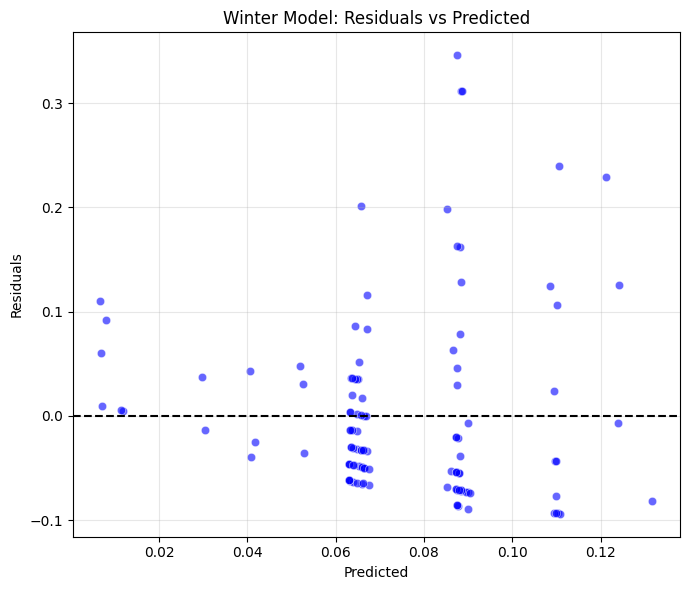

In [794]:
# Residual Plot - Winter
plt.figure(figsize=(7, 6))
sns.scatterplot(x=LRwinter.predict(Xw_train_scaled), y=residuals_winter, color='blue', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Winter Model: Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

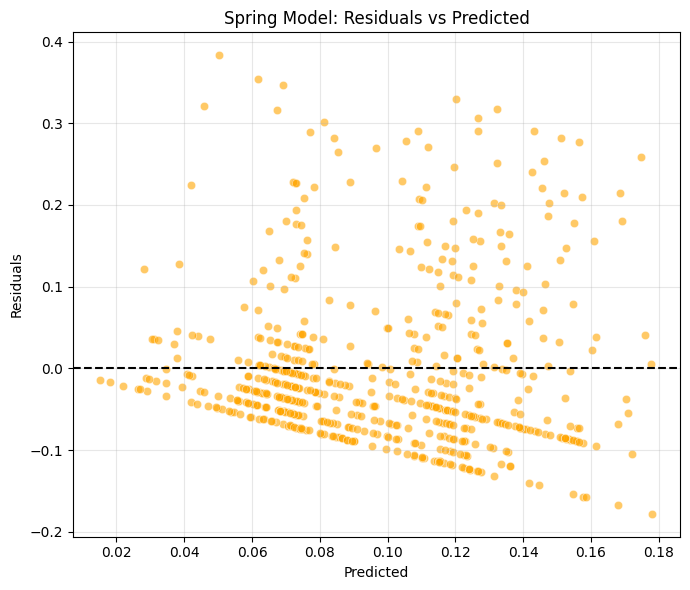

In [795]:
# Residual Plot - Spring
plt.figure(figsize=(7, 6))
sns.scatterplot(x=LRspring.predict(Xs_train_scaled), y=residuals_spring, color='orange', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Spring Model: Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

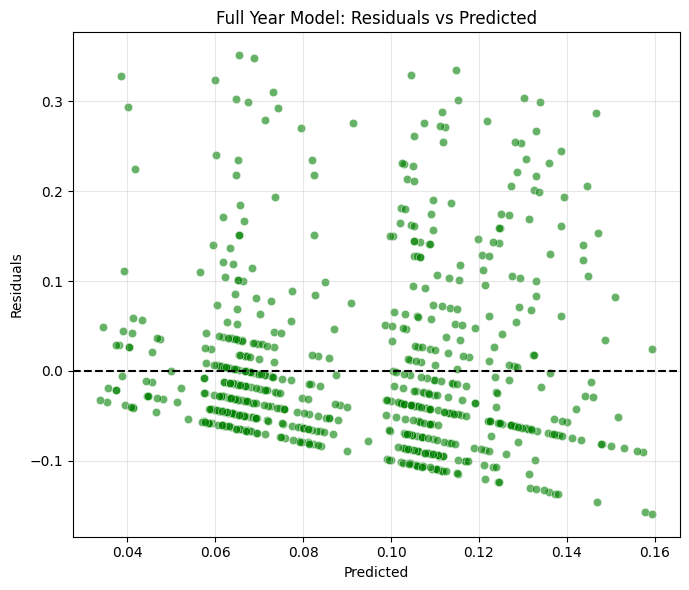

In [796]:
# Residual Plot - Full Year
plt.figure(figsize=(7, 6))
sns.scatterplot(x=LRyear.predict(Xy_train_scaled), y=residuals_year, color='green', alpha=0.6)
plt.axhline(0, linestyle='--', color='black')
plt.title("Full Year Model: Residuals vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Histogram of Residual

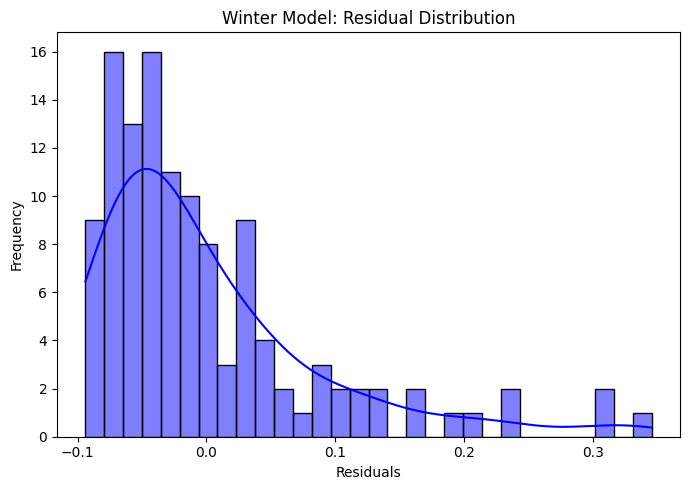

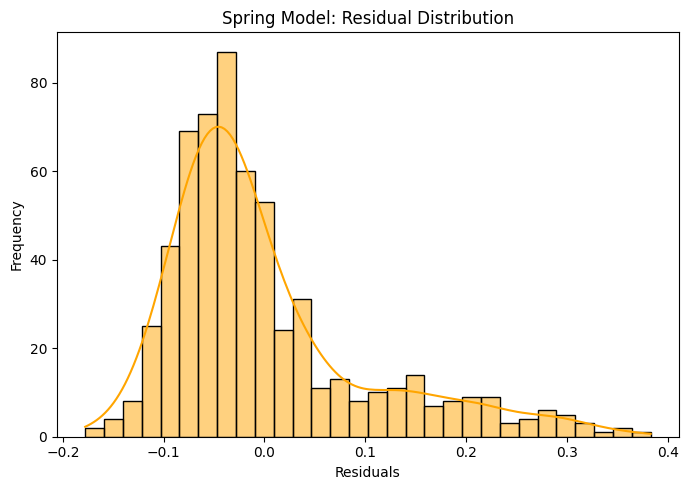

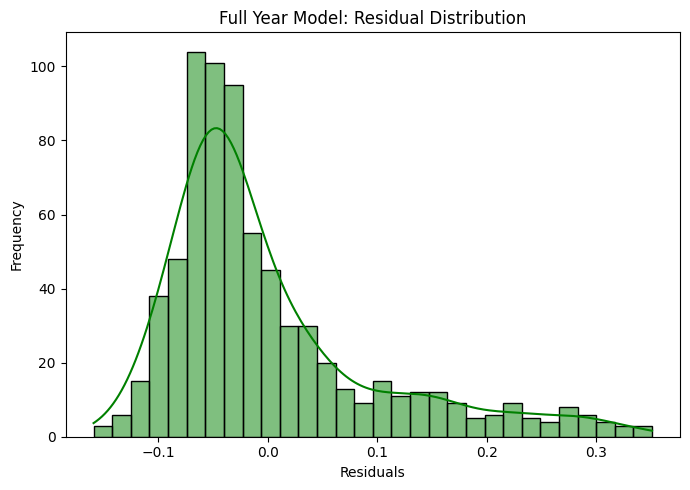

In [797]:
# Histogram of Residuals - Winter
plt.figure(figsize=(7, 5))
sns.histplot(residuals_winter, kde=True, color='blue', bins=30)
plt.title("Winter Model: Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram of Residuals - Spring
plt.figure(figsize=(7, 5))
sns.histplot(residuals_spring, kde=True, color='orange', bins=30)
plt.title("Spring Model: Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram of Residuals - Full Year
plt.figure(figsize=(7, 5))
sns.histplot(residuals_year, kde=True, color='green', bins=30)
plt.title("Full Year Model: Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## QQ Plot 

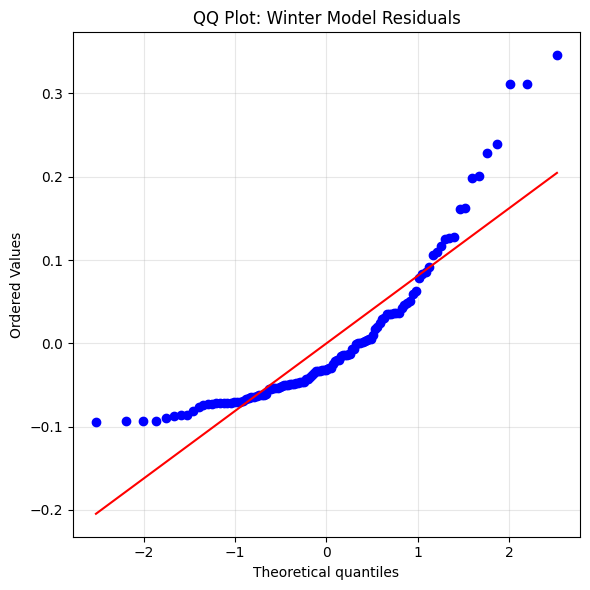

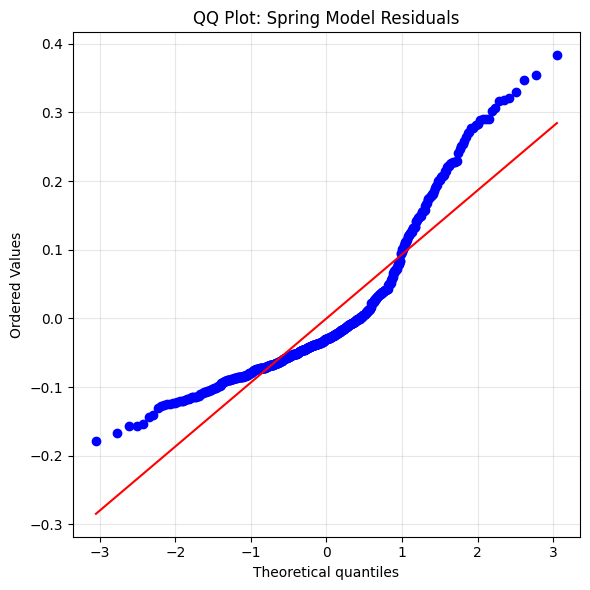

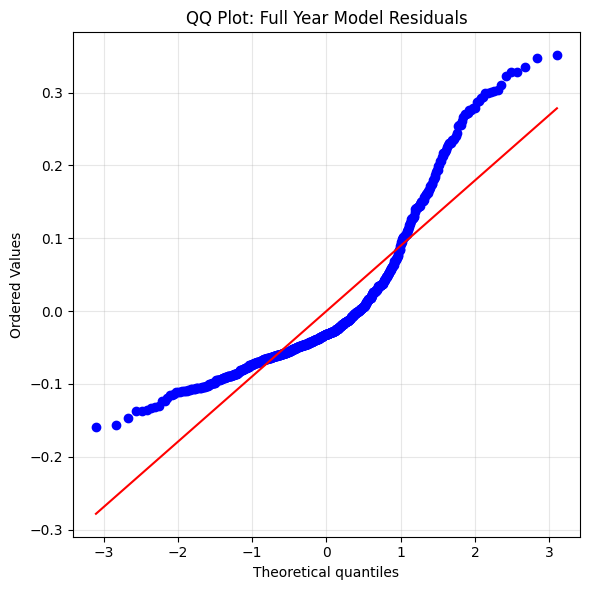

In [798]:

# QQ Plot - Winter Residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals_winter, dist="norm", plot=plt)
plt.title("QQ Plot: Winter Model Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# QQ Plot - Spring Residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals_spring, dist="norm", plot=plt)
plt.title("QQ Plot: Spring Model Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# QQ Plot - Full Year Residuals
plt.figure(figsize=(6, 6))
stats.probplot(residuals_year, dist="norm", plot=plt)
plt.title("QQ Plot: Full Year Model Residuals")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization

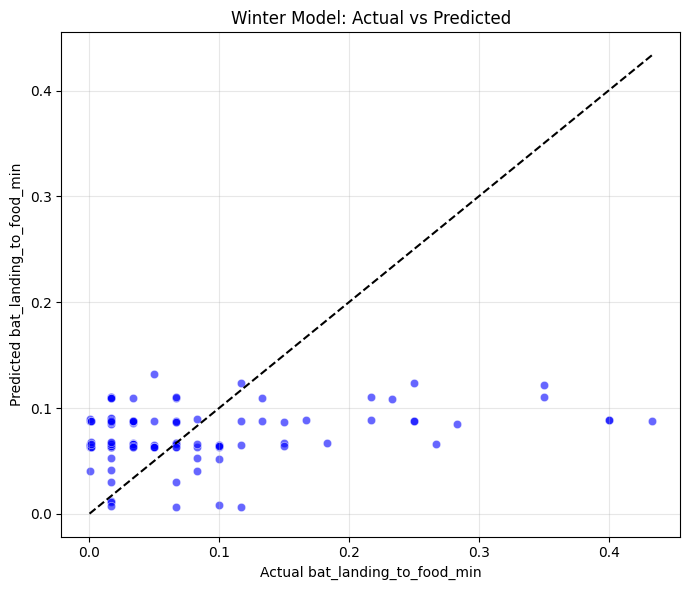

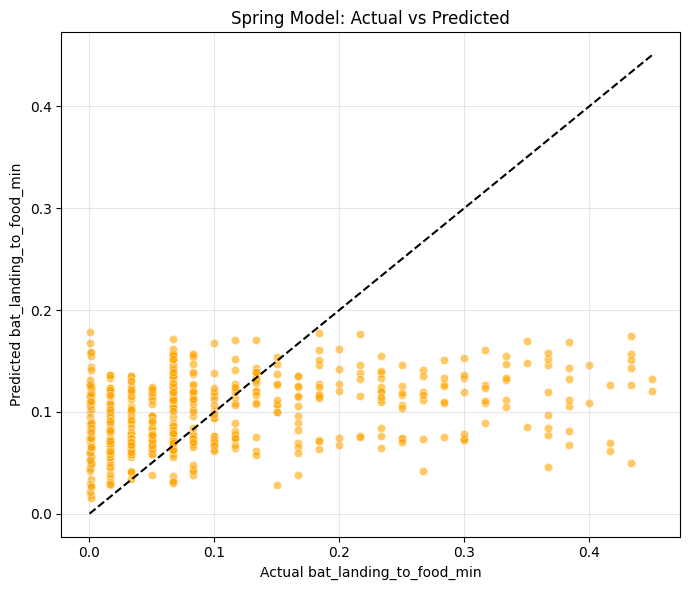

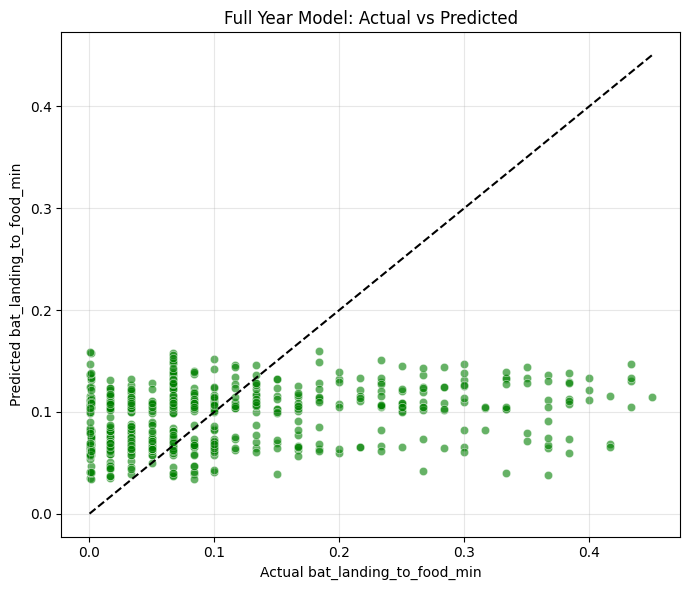

In [799]:
# Create DataFrames for plotting
df_winter_pred = pd.DataFrame({
    'Actual': yw_train.reset_index(drop=True),
    'Predicted': y_pred_winter,
    'Season': 'Winter'
})

df_spring_pred = pd.DataFrame({
    'Actual': ys_train.reset_index(drop=True),
    'Predicted': y_pred_spring,
    'Season': 'Spring'
})

df_year_pred = pd.DataFrame({
    'Actual': yy_train.reset_index(drop=True),
    'Predicted': y_pred_year,
    'Season': 'Full Year'
})

# --- Winter Plot ---
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_winter_pred, x='Actual', y='Predicted', color='blue', alpha=0.6)
sns.lineplot(x=[df_winter_pred['Actual'].min(), df_winter_pred['Actual'].max()],
             y=[df_winter_pred['Actual'].min(), df_winter_pred['Actual'].max()],
             color='black', linestyle='--')
plt.title('Winter Model: Actual vs Predicted')
plt.xlabel('Actual bat_landing_to_food_min')
plt.ylabel('Predicted bat_landing_to_food_min')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Spring Plot ---
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_spring_pred, x='Actual', y='Predicted', color='orange', alpha=0.6)
sns.lineplot(x=[df_spring_pred['Actual'].min(), df_spring_pred['Actual'].max()],
             y=[df_spring_pred['Actual'].min(), df_spring_pred['Actual'].max()],
             color='black', linestyle='--')
plt.title('Spring Model: Actual vs Predicted')
plt.xlabel('Actual bat_landing_to_food_min')
plt.ylabel('Predicted bat_landing_to_food_min')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Full Year Plot ---
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_year_pred, x='Actual', y='Predicted', color='green', alpha=0.6)
sns.lineplot(x=[df_year_pred['Actual'].min(), df_year_pred['Actual'].max()],
             y=[df_year_pred['Actual'].min(), df_year_pred['Actual'].max()],
             color='black', linestyle='--')
plt.title('Full Year Model: Actual vs Predicted')
plt.xlabel('Actual bat_landing_to_food_min')
plt.ylabel('Predicted bat_landing_to_food_min')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary

- **Data & Variables:**
    - We have two main seasonal datasets: `winter_df` and `spring_df`, each with features engineered for regression analysis.
    - The target variable for regression is `bat_landing_to_food_min`.
    - Feature lists for regression are defined as `w_features` (winter) and `s_features` (spring).
    - Data is split into train/test sets for both seasons (`yw_train`, `yw_test`, `ys_train`, `ys_test`).

- **Regression & Evaluation:**  
    - Linear regression models are trained and evaluated for both seasons.
    - Predictions for train and test sets are stored in variables like `y_pred_winter`, `y_pred_winter_test`, `y_pred_spring`, `y_pred_spring_test`.
    - Model performance is measured using MSE, RMSE, and R scores, both for train/test splits and cross-validation.
    - Cross-validation metrics are stored in lists such as `winter_mse_scores`, `winter_rmse_scores`, `winter_r2_scores`, `spring_mse_scores`, `spring_rmse_scores`, `spring_r2_scores`.

- **Feature Engineering & Multicollinearity:**  
    - Features include time intervals, risk/reward, food fraction, and seasonal indicators.
    - Multicollinearity is checked using correlation (`z` list) and VIF (`vif_data` DataFrame).
    - Highly correlated feature pairs are identified in `z`.

- **Standardization:**  
    - Features are standardized using `StandardScaler` objects (`winter_scaler`, `spring_scaler`).


# Regression Analysis Summary

## Model Performance Metrics

### Winter Model Performance (Poor Generalization)

The Winter model showed highly concerning performance on unseen data, failing to generalize effectively.

| Evaluation Set | R-squared ($R^2$) | MSE | RMSE |
| :---: | :---: | :---: | :---: |
| **Training** | 0.0701 | 0.0078 | 0.0884 |
| **Test** | **-0.1227** | 0.0131 | 0.1145 |
| **Cross-Validation (Avg.)** | -0.0557 | 0.0094 | 0.0965 |

<br>

> * **Interpretation:** The **Test Set $R^2$ of $-0.1227$** strongly suggests the linear relationship identified during training is either highly sensitive to the specific training data or that the underlying relationship is highly non-linear and cannot be approximated by a straight line, especially when faced with the variability of the test set.

### Spring Model Performance (Low Predictive Power)

The Spring model performs slightly better, but its predictive capability remains weak, with minimal variance explained.

| Evaluation Set | R-squared ($R^2$) | MSE | RMSE |
| :---: | :---: | :---: | :---: |
| **Training** | 0.1018 | 0.010 | 0.1001 |
| **Test** | -0.0711 | 0.0100 | 0.1004 |
| **Cross-Validation (Avg.)** | 0.0520 | 0.0102 | 0.1009 |

<br>

> * **Interpretation:** The **Test Set $R^2$ of $-0.0711$** means the model is unreliable and invalid for making predictions on new data. The low training **$R^2$ of $0.1018$** still suggests underfitting, where the model is too simple to capture the true, likely non-linear, relationship between the features and the target.

### Full Model Performance (Low Predictive Power)

The Full model, trained on the combined seasonal dataset, performs marginally better than the seasonal models but still exhibits weak predictive power and poor generalization. 

| Evaluation Set | R-squared ($R^2$) | MSE | RMSE |
| :---: | :---: | :---: | :---: |
| **Training** | 0.0785 | 0.0095 | 0.0972 |
| **Test** | 0.0267 | 0.0116 | 0.1079 |
| **Cross-Validation (Avg.)** | 0.0508 | 0.0100 | 0.1000 |

<br>

> * **Interpretation:** The **Test Set $R^2$ of $0.0264$** indicates that the model explains only 2.67% of the variance in unseen data. The modest training R^2 of 0.0785 suggests underfitting, and the near identical cross validation metrics reinforce the conclusion that the model lacks the complexity needed to capture meaningful patterns across the full dataset.


## Conclusion

The pervasive low $R^2$ values, particularly the negative scores on both test sets, confirm that the current structure of the `bat_landing_to_food_min` dataset, when paired with the chosen features, is **unsuitable for modeling with Linear Regression**. The complexity of the bat's behavior likely requires a more flexible approach. 